# Kaggle Titanic: 1 - Data Exploration & Feature Engineering

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import ks_2samp, gaussian_kde

import missingno as msno

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             classification_report, roc_auc_score,
                             roc_curve)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Add the "src" directory to the system path
project_root  = os.path.abspath('../')

if project_root not in sys.path:
    sys.path.append(project_root)

from src.utils import EnvironmentInfo, PathManager
from src.project_specific import create_data_dictionnary_df, DataOverview, type_conversion, get_data_types, fare_missing_values_imputation, embarked_missing_value_imputation, delete_features, add_features, extract_title_lastname, manage_titles, extract_deck, extract_family_alone, create_combined_dataset, replace_missing_age_with_median



## Working Environment

### List physical devices

In [2]:
env_info = EnvironmentInfo()
print(env_info)

No GPU available

CPU details: AMD64 Family 25 Model 80 Stepping 0, AuthenticAMD

Detailed CPU information:
Physical cores: 8
Total cores: 16
Max Frequency: 2000.00MHz
Min Frequency: 0.00MHz
Current Frequency: 2000.00MHz


### Variables & Paths

In [3]:
path_manager = PathManager(dataset_name="titanic")
print("\n" + str(path_manager))

DATASET_PATH = path_manager.dataset_path
WORKING_PATH = path_manager.working_path

print(f"\nDATASET_PATH: {DATASET_PATH}")
print(f"WORKING_PATH: {WORKING_PATH}")

Running on local.
Dataset directory: c:\Users\Florent\Documents\data_science\kaggle-titanic\data
Working directory: c:\Users\Florent\Documents\data_science\kaggle-titanic\data\working

Dataset Path: c:\Users\Florent\Documents\data_science\kaggle-titanic\data
Working Path: c:\Users\Florent\Documents\data_science\kaggle-titanic\data\working

DATASET_PATH: c:\Users\Florent\Documents\data_science\kaggle-titanic\data
WORKING_PATH: c:\Users\Florent\Documents\data_science\kaggle-titanic\data\working


#### Datasets

In [4]:
test = pd.read_csv(os.path.join(DATASET_PATH, "test.csv"))
train = pd.read_csv(os.path.join(DATASET_PATH, "train.csv"))

datasets_dict = {
    "train": train,
    "test": test
}

test_memory = test.memory_usage(deep=True).sum()
train_memory = train.memory_usage(deep=True).sum()
print(f"Test dataset memory usage: {test_memory / (1024**2):.2f} MB")
print(f"Train dataset memory usage: {train_memory / (1024**2):.2f} MB")

Test dataset memory usage: 0.13 MB
Train dataset memory usage: 0.28 MB


## Data dictionnary

In [5]:
data_dictionnary_df = create_data_dictionnary_df()
print(data_dictionnary_df.to_string(index=False))

   Variable                        Definition                                            Key                                                                                                             Note
PassengerId     Passenger's unique identifier                                      Unique ID                                                                                                                 
   Survived                   Survival status                                0 = No, 1 = Yes                                                                                                                 
     Pclass                      Ticket class                      1 = 1st, 2 = 2nd, 3 = 3rd                                                                                  Proxy for socio-economic status
       Name                  Passenger's name                                                                                                                                   

## Data overview

The aim of this part is to get a brief overview of the data.  
This will help us to understand the data and to identify any potential issues that we may need to address later on, such as missing values, data types, unbalanced distributions...

Starting data exploration on multiple DataFrames.

=== Data Overview: train ===
- Shape of the dataset: (891, 12)
- First five rows:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



- Summary Statistics:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN



=== Missing Values Analysis: train ===
- Missing values in each column:
Age         177
Cabin       687
Embarked      2
dtype: int64

- Visualizing missing values:


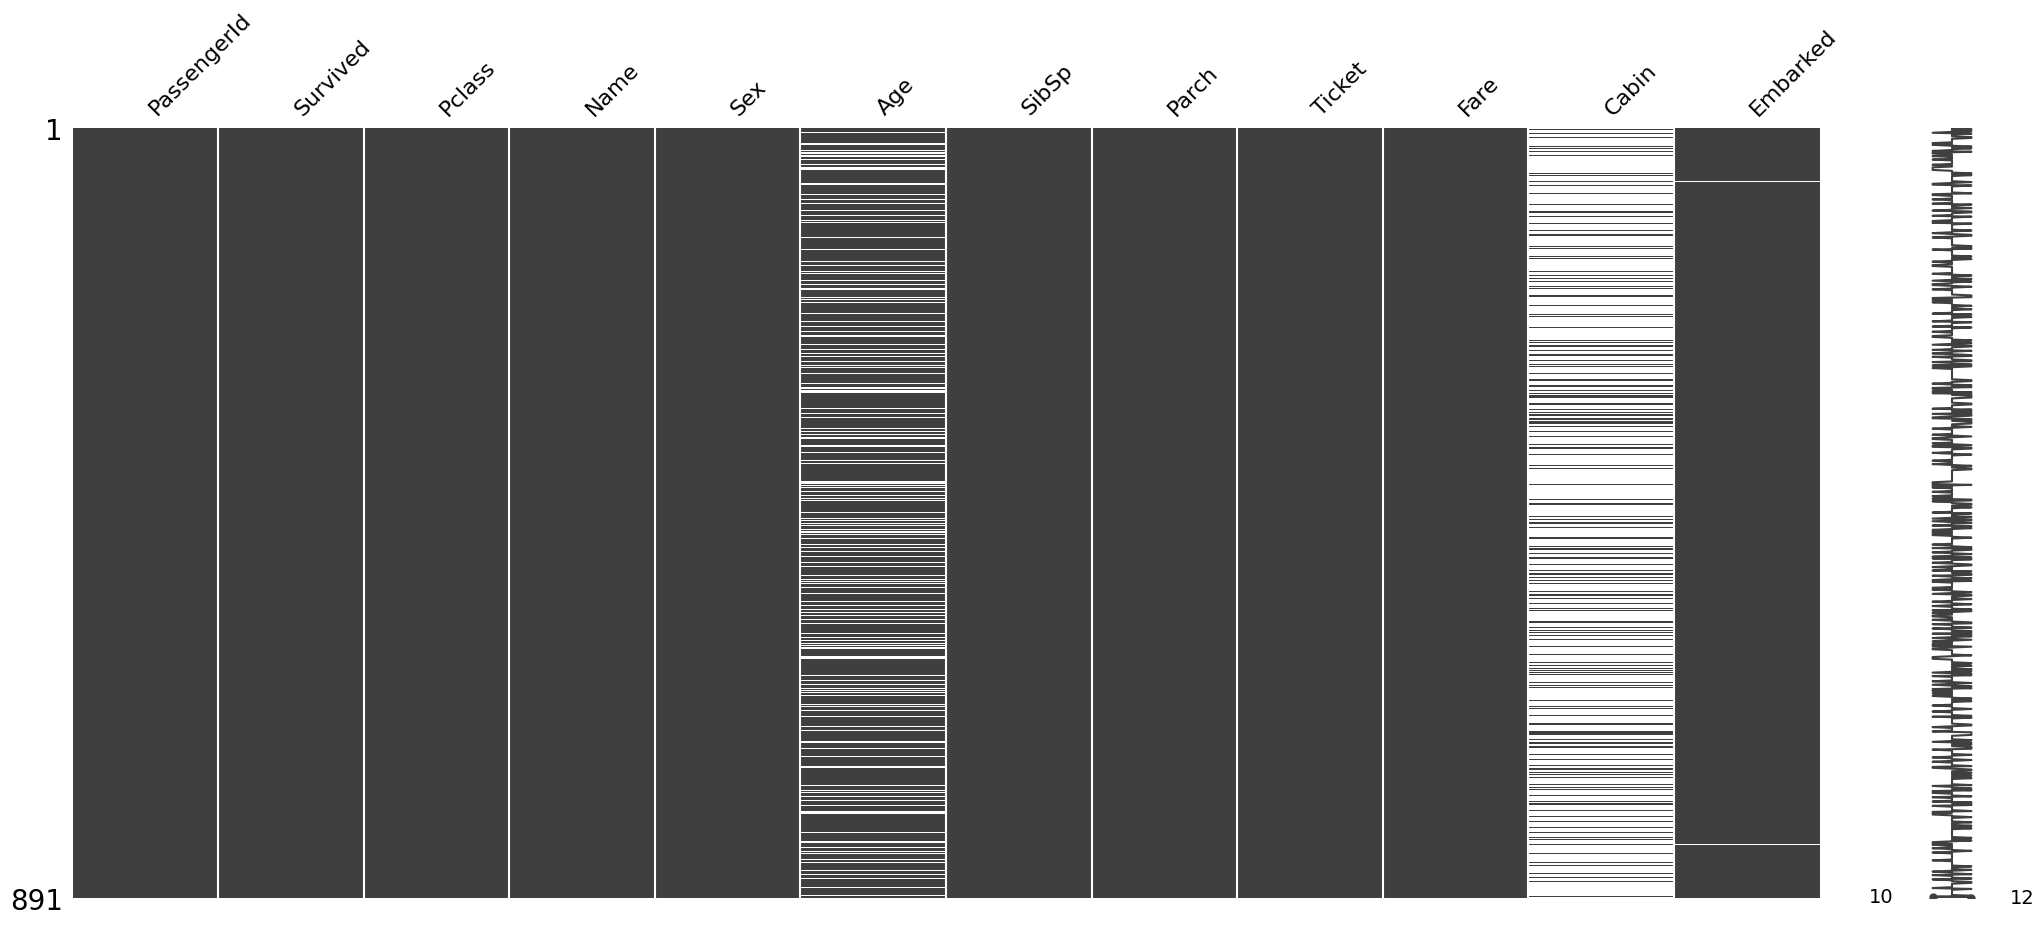


=== Duplicate Detection: train ===
Number of duplicate rows: 0

=== Data Types: train ===
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

 => Numerical and categorical features based on types

Numerical Features: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical Features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

=== Data Overview: test ===
- Shape of the dataset: (418, 11)
- First five rows:


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S



- Summary Statistics:


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN



=== Missing Values Analysis: test ===
- Missing values in each column:
Age       86
Fare       1
Cabin    327
dtype: int64

- Visualizing missing values:


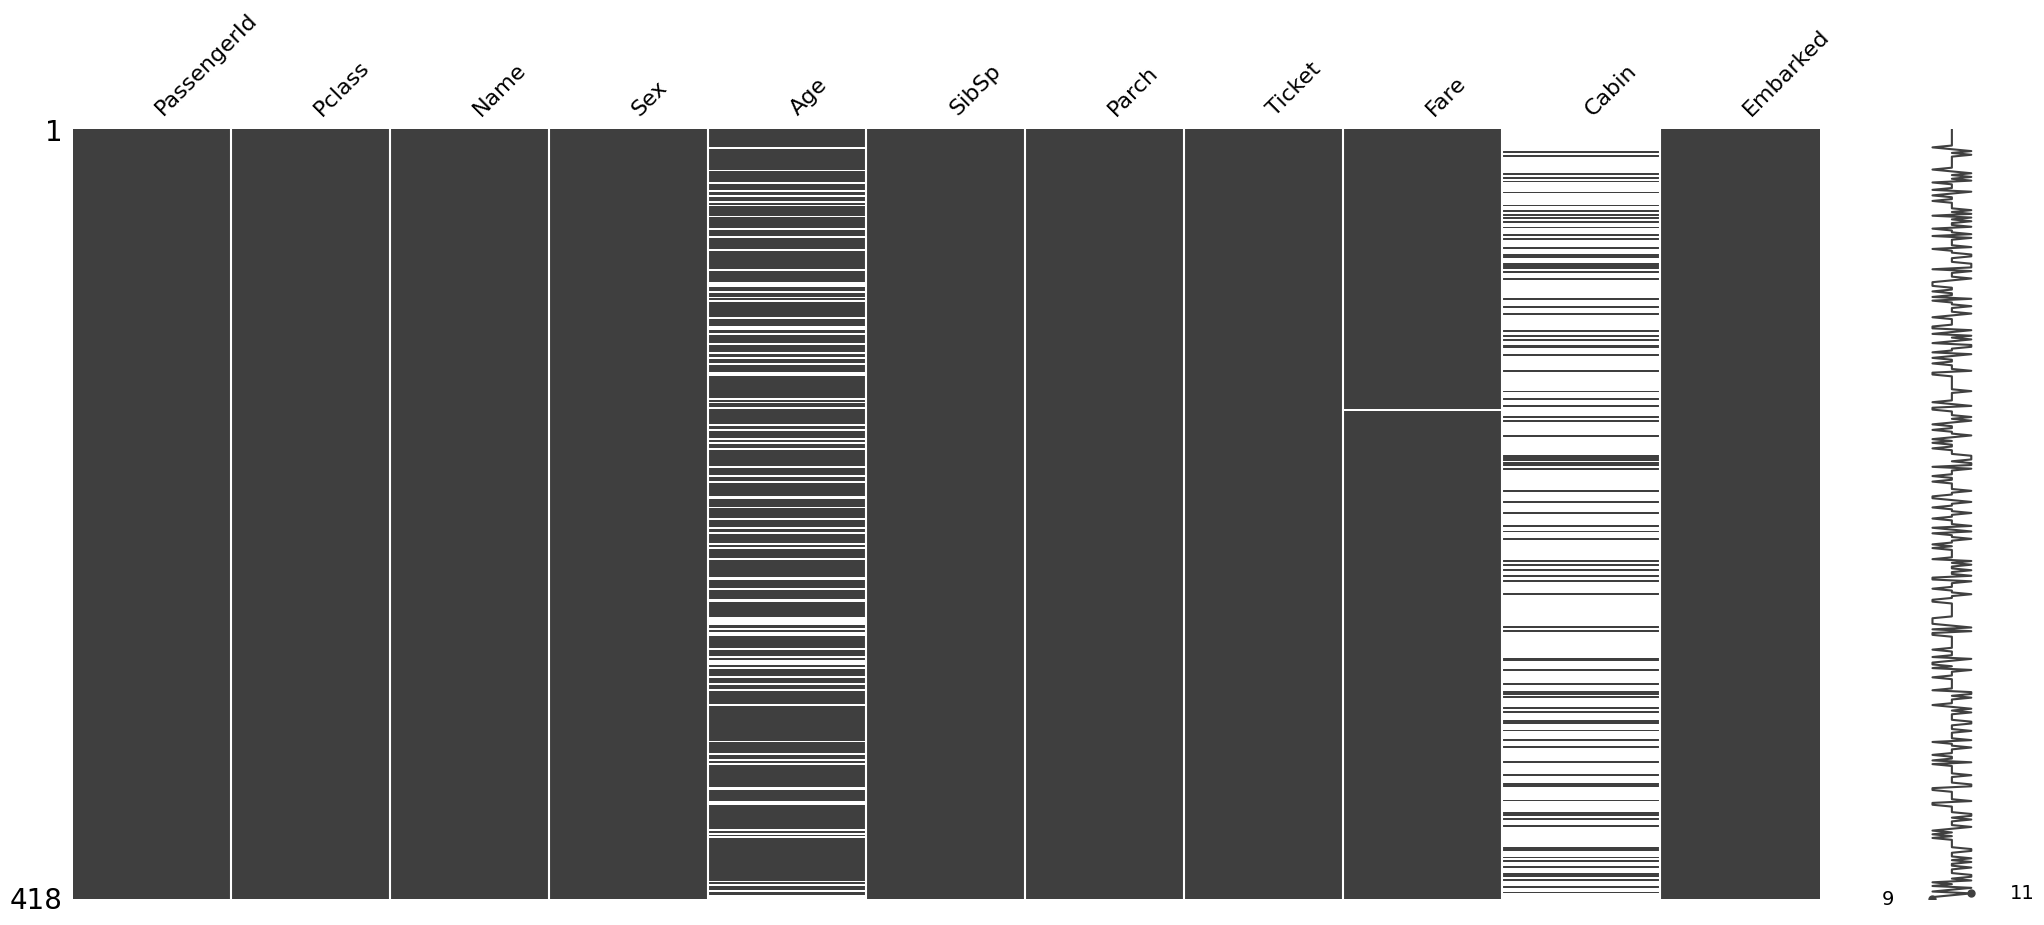


=== Duplicate Detection: test ===
Number of duplicate rows: 0

=== Data Types: test ===
PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

 => Numerical and categorical features based on types

Numerical Features: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical Features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [6]:
data_overview = DataOverview()
data_overview.data_exploration(datasets_dict)

## Data Management

Based on the data overview step, there are some data mangement step swe need to do such as : 
- type conversion,
- missing value management,
- extract relevant information from some features that seems too heterogeneous.

### Data Types & Type conversion

- Pclass : changed to categorical type for analysis on test and train datasets

In [7]:
train = type_conversion(df=train, columns_to_convert=['Pclass'])
test = type_conversion(df=test, columns_to_convert=['Pclass'])

### Features Lists

In [8]:
numerical_features_train, categorical_features_train = get_data_types(train, target_variable='Survived')
numerical_features_test, categorical_features_test = get_data_types(test, target_variable='Survived')


Numerical Features: ['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical Features: ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Target Variable: Survived

Numerical Features: ['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical Features: ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Target Variable 'Survived' not found in DataFrame.


### Missing values

- Features with more than 60% of missing values.

In [9]:
valeur_60pc_test = len(test) * 0.6
valeur_60pc_train = len(train) * 0.6

print("test:\n", test.isna().sum(), '\n')
print("valeur 60% na test:", valeur_60pc_test, '\n')

print("train:\n", train.isna().sum(), '\n')
print("valeur 60% na train:", valeur_60pc_train)

test:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64 

valeur 60% na test: 250.79999999999998 

train:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 

valeur 60% na train: 534.6


Missing values management : 
- 'Cabin' >60% missing values: will not be used in analysis, the relevant information will extacted in 'Deck' before deletion
- 'Fare': Impute Median Fare by 'Pclass' and 'Embarked'
- 'Embarked': Imputation from similar passengers according to 'Fare' and 'Pclass'
- 'Age': machine learning prediction, using 'Title' extracted from 'Name', or median value by subgroups if ML imputations are not good enough

#### Fare (in test dataset)
Impute Median Fare by 'Pclass' and 'Embarked'.

In [10]:
test = fare_missing_values_imputation(df_test=test, df_train=train)

'Embarked' is S for passenger at index 152. Imputing 'Fare' with median fare 8.05 for 'Pclass' 3 and 'Embarked' S.

After imputation:
Remaining missing 'Fare' values in test dataset: 0


#### Embarked (in train dataset)
Imputation from similar passengers according to 'Fare' and 'Pclass'.

In [11]:
missing_embarked = train[train['Embarked'].isnull()]
display(missing_embarked)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [12]:
combined = create_combined_dataset(train_df=train, test_df=test)

similar_passengers = combined[(combined['Fare'] >= 79.0) & (combined['Fare'] <= 81.0) & (combined['Pclass'] == '1')]

print("Mode of Embarked:", combined['Embarked'].mode()[0])
display(similar_passengers['Embarked'].value_counts())
print(similar_passengers)

Mode of Embarked: S


Embarked
C    6
S    3
Name: count, dtype: int64

     PassengerId  Survived Pclass  \
61            62       1.0      1   
139          140       0.0      1   
256          257       1.0      1   
262          263       0.0      1   
558          559       1.0      1   
585          586       1.0      1   
587          588       1.0      1   
789          790       0.0      1   
829          830       1.0      1   
327         1219       NaN      1   
397         1289       NaN      1   

                                                  Name     Sex   Age  SibSp  \
61                                 Icard, Miss. Amelie  female  38.0      0   
139                                 Giglio, Mr. Victor    male  24.0      0   
256                     Thorne, Mrs. Gertrude Maybelle  female   NaN      0   
262                                  Taussig, Mr. Emil    male  52.0      1   
558             Taussig, Mrs. Emil (Tillie Mandelbaum)  female  39.0      1   
585                                Taussig, Miss. Ruth  female  18.0      0   
58

=> Based on the cabin number the deck is 'B', it might make more sense to use 'C' for embarked instead of 'S'.

In [13]:
train = embarked_missing_value_imputation(train)


After imputation:
Remaining missing 'Embarked' values in train dataset: 0


#### Age (in both test and train datasets)

- Age is a numerical feature, we can try machine learning to predict the missing values: 
- is Age missing at random ? 

=> Age imputation will be done after the feature engineering step as new features will be used.

### Features creation and deletion

- Creating Simplified from Name (with Title and Last Name)
- Deleting Name
- Creating Deck from Cabin
- Deleting Cabin
- Creating Family Size on board from Sibsp + Parch
- Deleting Sibsp and Parch
- Creating Traveling Alone from Family size on board
- Deleting Ticket

#### Creating Simplified Title from Name

##### Creating Last Name and Title from Name

In [14]:
print(train.Name.head(10))

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object


In [15]:
train = extract_title_lastname(train)
test = extract_title_lastname(test)

print("Test\n", test.Title.value_counts())
print("\nTrain\n", train.Title.value_counts())

Test
 Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64

Train
 Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64


In [16]:
print("Test\n", test.Last_Name.value_counts())
print("\nTrain\n", train.Last_Name.value_counts())

Test
 Last_Name
Davies      4
Asplund     4
Ware        4
Thomas      4
Sage        4
           ..
Spinner     1
Petersen    1
Bowenur     1
McCoy       1
Peter       1
Name: count, Length: 352, dtype: int64

Train
 Last_Name
Andersson    9
Sage         7
Panula       6
Skoog        6
Carter       6
            ..
Hanna        1
Lewy         1
Mineff       1
Haas         1
Dooley       1
Name: count, Length: 667, dtype: int64


Too few people share the same lastname, we can only keep the title contained within the 'Name' column.

From the value counts, Title seems to be very correlated with Sex.

- Correlations between Title and Sex.
- Only "Child" information is relevant ?

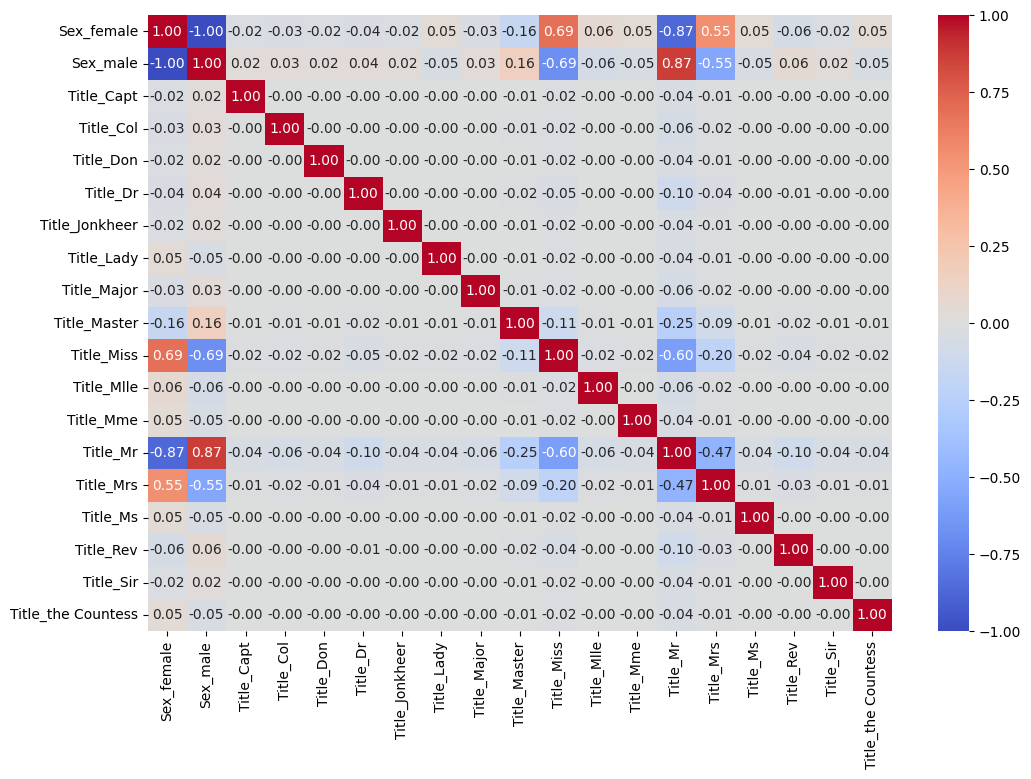

In [17]:
encoded_df = pd.get_dummies(train[['Sex', 'Title']], drop_first=False)
correlation_matrix = encoded_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

Values Mr, Mrs and Miss are strongly asociated with Male and Female, these values are also the most represented in the dataset.  

We can keep only the information if the passenger is a child ('Master') and if he or she has some title in a new feature: Simplified Title.  

Name, LastName and Title can be deleted.

In [18]:
train = manage_titles(train)
test = manage_titles(test)

print("Test\n", test.Simplified_Title.value_counts())
print("\nTrain\n", train.Simplified_Title.value_counts())

Test
 Simplified_Title
Commoner    392
Child        21
Title         5
Name: count, dtype: int64

Train
 Simplified_Title
Commoner    829
Child        40
Title        22
Name: count, dtype: int64


Add Simplified TItle to the features lists:

In [19]:
categorical_features_train = add_features(
    var_list=categorical_features_train,
    features_to_add=['Simplified_Title']
)
categorical_features_test = add_features(
    var_list=categorical_features_test,
    features_to_add=['Simplified_Title']
)

Features: ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Simplified_Title']
Features: ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Simplified_Title']


#### Creation of Deck from Cabin

In [20]:
test = extract_deck(test)
train = extract_deck(train)

print("test: ", test.Deck.value_counts())
print("\ntrain: ", train.Deck.value_counts())

test:  Deck
Unknown    327
C           35
B           18
D           13
E            9
F            8
A            7
G            1
Name: count, dtype: int64

train:  Deck
Unknown    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: count, dtype: int64


Add Deck to the features lists:

In [21]:
categorical_features_train = add_features(
    var_list=categorical_features_train,
    features_to_add=['Deck']
)
categorical_features_test = add_features(
    var_list=categorical_features_test,
    features_to_add=['Deck']
)

Features: ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Simplified_Title', 'Deck']
Features: ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Simplified_Title', 'Deck']


Cabin has too many values, and a lot of nan, as the main information (Deck) has been extracted, we can delete cabin.

In [22]:
print(train.Cabin.dropna().unique()[:20])
print(train.Cabin.dropna().nunique())
print(train.Cabin.isna().sum())

['C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33' 'B30'
 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26']
147
687


#### Deletion of Name, Last Name, Title, Cabin, Ticket

Ticket has too many unique values as well:

In [23]:
print(train.Ticket.unique()[:20])
print(train.Ticket.nunique())
print(train.Ticket.isna().sum())

['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450' '330877'
 '17463' '349909' '347742' '237736' 'PP 9549' '113783' 'A/5. 2151'
 '347082' '350406' '248706' '382652' '244373' '345763' '2649']
681
0


In [24]:
to_delete = ['Name', 'LastName', 'Title', 'Cabin', 'Ticket']
categorical_features_train = delete_features(var_list=categorical_features_train, var_to_delete=to_delete)
categorical_features_test = delete_features(var_list=categorical_features_test, var_to_delete=to_delete)

Features: ['Pclass', 'Sex', 'Embarked', 'Simplified_Title', 'Deck']
Features: ['Pclass', 'Sex', 'Embarked', 'Simplified_Title', 'Deck']


#### Creation of Family Size on board and Traveling Alone

In [25]:
test = extract_family_alone(test)
train = extract_family_alone(train)

print("test: Family_Size", test.Family_Size.describe(include='all'))
print("\ntrain: Family_Size", train.Family_Size.describe(include='all'))
print("\ntest: ", test.Is_Alone.value_counts())
print("\ntrain: ", train.Is_Alone.value_counts())

test: Family_Size count    418.000000
mean       1.839713
std        1.519072
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       11.000000
Name: Family_Size, dtype: float64

train: Family_Size count    891.000000
mean       1.904602
std        1.613459
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       11.000000
Name: Family_Size, dtype: float64

test:  Is_Alone
1    253
0    165
Name: count, dtype: int64

train:  Is_Alone
1    537
0    354
Name: count, dtype: int64


Change Is_Alone type from int to str:

In [26]:
train = type_conversion(df=train, columns_to_convert=['Is_Alone'])
test = type_conversion(df=test, columns_to_convert=['Is_Alone'])

Add Family_Size ans Is_Alone to the features lists:

In [27]:
numerical_features_train = add_features(
    var_list=numerical_features_train,
    features_to_add=['Family_Size']
)
numerical_features_test = add_features(
    var_list=numerical_features_test,
    features_to_add=['Family_Size']
)

categorical_features_train = add_features(
    var_list=categorical_features_train,
    features_to_add=['Is_Alone']
)
categorical_features_test = add_features(
    var_list=categorical_features_test,
    features_to_add=['Is_Alone']
)

Features: ['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare', 'Family_Size']
Features: ['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare', 'Family_Size']
Features: ['Pclass', 'Sex', 'Embarked', 'Simplified_Title', 'Deck', 'Is_Alone']
Features: ['Pclass', 'Sex', 'Embarked', 'Simplified_Title', 'Deck', 'Is_Alone']


##### Delete Sibsp and parch

In [28]:
to_delete = ['SibSp', 'Parch']
numerical_features_train = delete_features(var_list=numerical_features_train, var_to_delete=to_delete)
numerical_features_test = delete_features(var_list=numerical_features_test, var_to_delete=to_delete)

Features: ['PassengerId', 'Age', 'Fare', 'Family_Size']
Features: ['PassengerId', 'Age', 'Fare', 'Family_Size']


### Imputations of Missing values for Age using new Features

#### Is Age Missing At Random ?

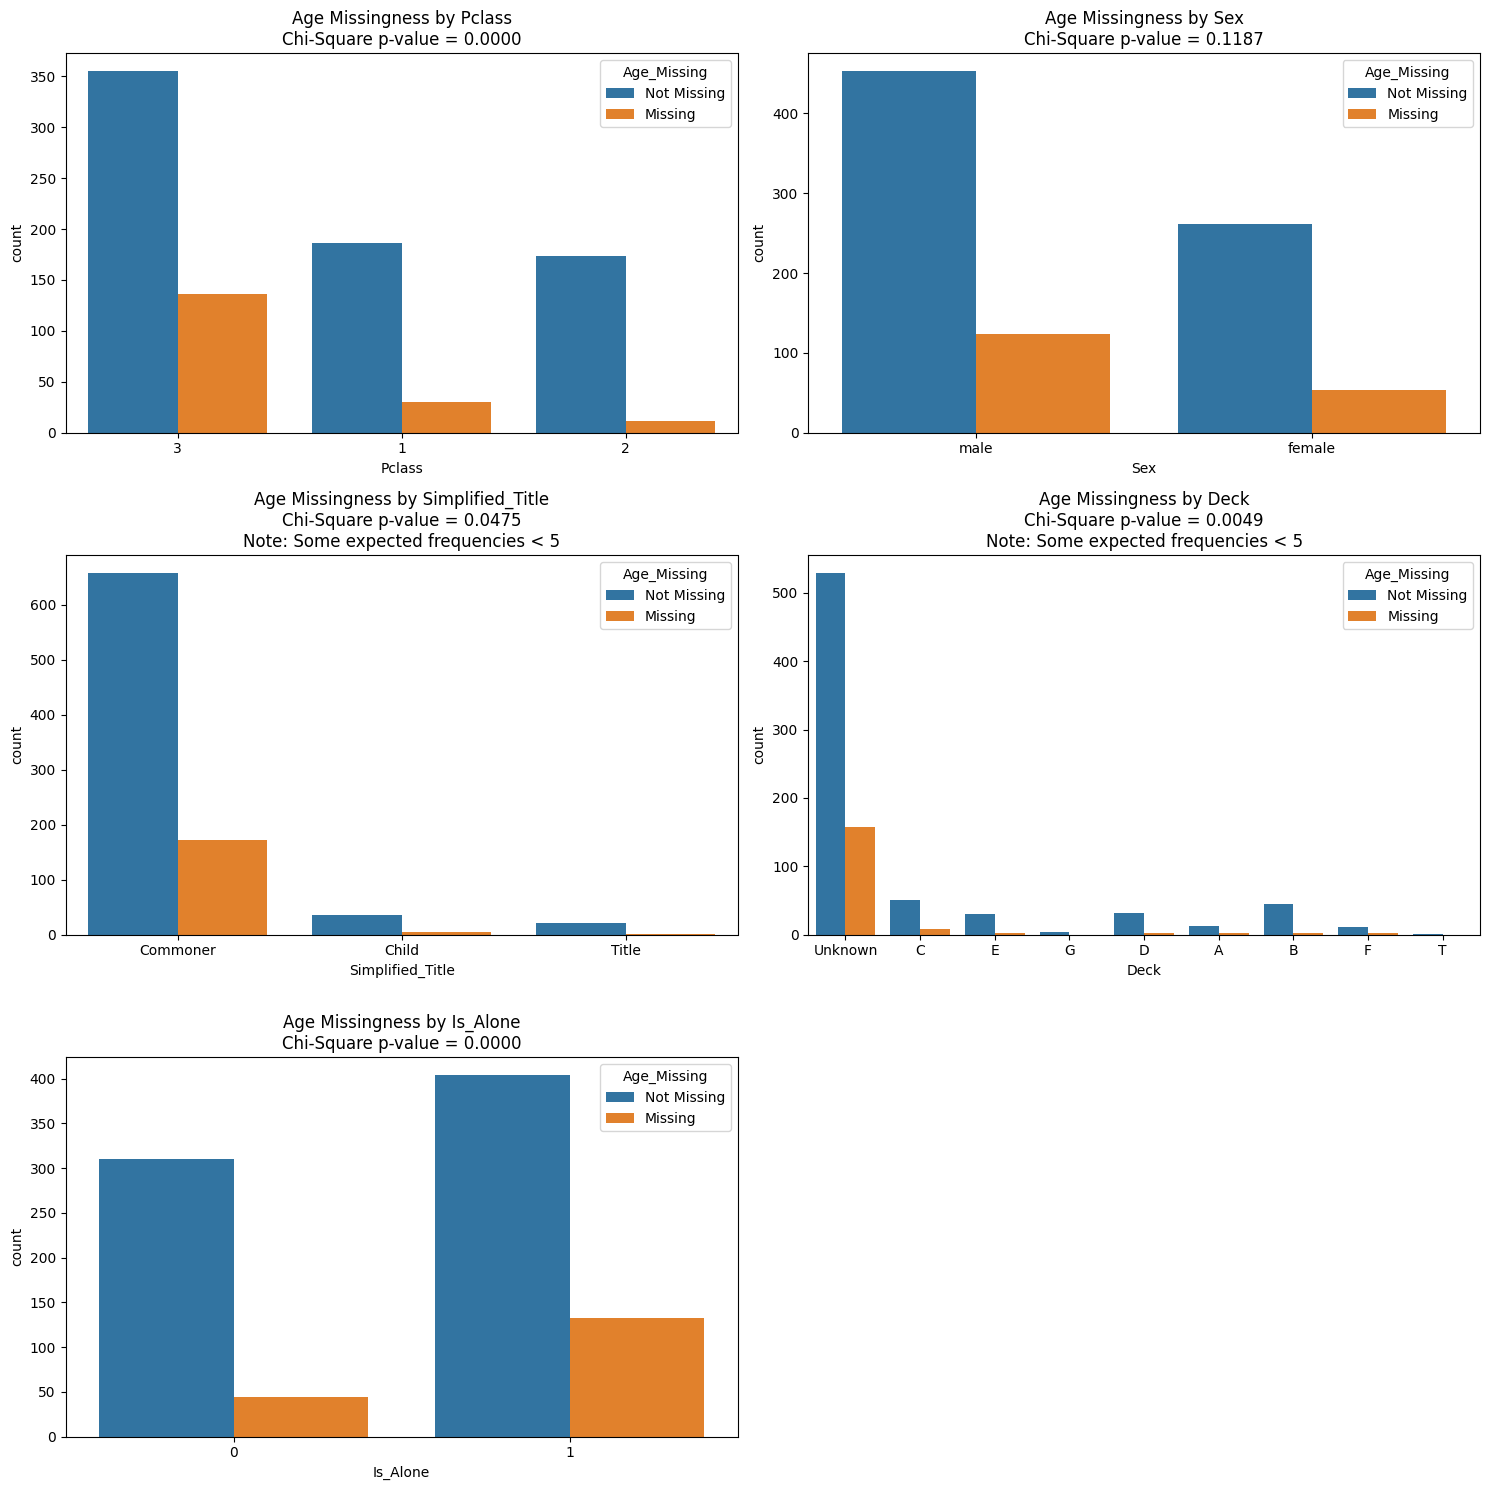

In [29]:
from scipy.stats import chi2_contingency


def plot_count_with_pvalue(df, feature, hue='Age_Missing', ax=None):
    """
    Creates a countplot for a given feature with hue and annotates it with the Chi-Square p-value.
    If expected frequencies are too low, annotates accordingly.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - feature (str): The categorical feature to plot on the x-axis.
    - hue (str): The feature to use for hue (default is 'Age_Missing').
    - ax (matplotlib.axes.Axes): The axes on which to plot (default is None).
    """
    if ax is None:
        ax = plt.gca()

    sns.countplot(x=feature, hue=hue, data=df, ax=ax)

    # Perform Chi-Square Test
    contingency_table = pd.crosstab(df[feature], df[hue])
    chi2, p, dof, ex = chi2_contingency(contingency_table)

    # Check for expected frequencies
    if (ex < 5).any():
        annotation = f"Chi-Square p-value = {p:.4f}\nNote: Some expected frequencies < 5"
    else:
        annotation = f"Chi-Square p-value = {p:.4f}"

    # Annotate p-value on the plot
    ax.set_title(f'Age Missingness by {feature}\n{annotation}')
    ax.legend(title=hue, labels=['Not Missing', 'Missing'])


def plot_all_counts_with_pvalue(df, cat_features, hue='Age_Missing'):
    """
    Creates a grid of countplots for given categorical features with hue and annotates each with the Chi-Square p-value.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - cat_features (list of str): The list of categorical features to plot.
    - hue (str): The feature to use for hue (default is 'Age_Missing').
    """
    n_features = len(cat_features)
    n_cols = 2  # Number of columns in the subplot grid
    n_rows = (n_features + n_cols - 1) // n_cols  # Number of rows in the subplot grid

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(cat_features):
        plot_count_with_pvalue(df, feature, hue=hue, ax=axes[i])

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()



train['Age_Missing'] = train['Age'].isnull().astype(int)
cat_features = ['Pclass', 'Sex', 'Simplified_Title', 'Deck', 'Is_Alone']

plot_all_counts_with_pvalue(train, cat_features)

Age is missing are random (MAR) because age missingness is associated with 'Pclass' and 'Is Alone', but there is apparently no clear pattern of missingness.  

There are some cases where the chi square is not really appropriate as some combinations of missing x subgroup have less than 5 observations, but still it gives us an idea that some subgoups have more missing values than others.

=> MAR Imputation with: KNN, Random Forest, XGBoost

##### KNN Imputation

In [30]:
features_for_imputation = ['Pclass', 'Sex', 'Family_Size', 'Is_Alone', 'Fare', 'Simplified_Title']
features_for_imputation_cat = ['Pclass', 'Sex', 'Family_Size', 'Is_Alone', 'Fare', 'Simplified_Title']

Model training on the combined dataset (test+train) with only non missing values for Age

In [31]:
combined = pd.concat([train, test], axis=0)
age_known = combined.dropna(subset=['Age'])
age_known = age_known[['Age'] + features_for_imputation]

In [32]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def preprocess_data(df, target_variable='Age'):
    """
    Preprocess the data by encoding categorical variables and normalizing numerical variables.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - target_variable (str): The target variable to impute.
    
    Returns:
    - X (pd.DataFrame): The preprocessed features.
    - y (pd.Series): The target variable.
    """
    # One-hot encode categorical variables
    df_encoded = pd.get_dummies(df, columns=features_for_imputation_cat, 
                                drop_first=True)

    # Normalize numerical features
    scaler = StandardScaler()
    X = scaler.fit_transform(df_encoded.drop(columns=[target_variable]))
    y = df[target_variable]
    
    return X, y

In [33]:
from sklearn.metrics import accuracy_score

def evaluate_knn_imputer_with_accuracy(df, target_variable='Age', n_neighbors=5, test_size=0.2, random_state=1, missing_fraction=0.2):
    """
    Evaluates the KNN imputer using MSE and accuracy by introducing artificial missingness and measuring reconstruction.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - target_variable (str): The target variable to impute.
    - n_neighbors (int): Number of neighbors for the KNN imputer.
    - test_size (float): Proportion of the dataset to include in the test split.
    - random_state (int): Random seed for reproducibility.
    - missing_fraction (float): Fraction of target values to mask for evaluation.
    
    Returns:
    - mse (float): Mean Squared Error between original and imputed values.
    - accuracy (float): Accuracy of imputed values (if rounded to discrete values).
    """
    # Preprocess the data
    X, y = preprocess_data(df, target_variable=target_variable)
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Introduce artificial missingness in the test target
    y_test_missing = y_test.copy()
    mask = np.random.rand(len(y_test)) < missing_fraction
    y_test_missing[mask] = np.nan

    # Combine X and y for imputation
    X_test_impute = np.column_stack([X_test, y_test_missing])
    
    # Train the KNN imputer
    imputer = KNNImputer(n_neighbors=n_neighbors)
    X_test_imputed = imputer.fit_transform(X_test_impute)
    
    # Extract the imputed target values
    y_test_imputed = X_test_imputed[:, -1]
    
    # Evaluate the imputation
    mse = mean_squared_error(y_test[mask], y_test_imputed[mask])
    y_test_rounded = np.round(y_test[mask])  # Round original values to nearest integer
    y_imputed_rounded = np.round(y_test_imputed[mask])  # Round imputed values
    
    accuracy = accuracy_score(y_test_rounded, y_imputed_rounded)
    print(f"Mean Squared Error of KNN Imputation: {mse:.4f}")
    print(f"Accuracy of KNN Imputation: {accuracy:.4f}")
    
    return mse, accuracy

In [34]:
mse, accuracy = evaluate_knn_imputer_with_accuracy(
    df=age_known,
    target_variable='Age',
    n_neighbors=6,
    missing_fraction=0.2
)

Mean Squared Error of KNN Imputation: 253.3921
Accuracy of KNN Imputation: 0.0238


##### Random Forest Imputation

In [35]:
from sklearn.ensemble import RandomForestRegressor

def predictive_imputation(df, target_variable='Age', test_size=0.2, random_state=1):
    """
    Imputes missing values using a predictive model (Random Forest).
    """
    X, y = preprocess_data(df, target_variable=target_variable)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Introduce artificial missingness
    y_test_missing = y_test.copy()
    mask = np.random.rand(len(y_test)) < 0.2
    y_test_missing[mask] = np.nan

    # Train a Random Forest model
    model = RandomForestRegressor(random_state=random_state)
    model.fit(X_train, y_train)
    
    # Predict missing values
    y_test_imputed = y_test_missing.copy()
    y_test_imputed[mask] = model.predict(X_test[mask])
    
    mse = mean_squared_error(y_test[mask], y_test_imputed[mask])
    print(f"Predictive Imputation MSE: {mse:.4f}")
    return mse

In [36]:
mse = predictive_imputation(
    df=age_known,
    target_variable='Age'
)

Predictive Imputation MSE: 152.8377


KNN and Random Forest imputations perform very poorly, so we will use Median value imputation instead.

##### Median value imputation

In [37]:
from itertools import product

all_combinations = pd.DataFrame(
    list(product(combined['Sex'].unique(), combined['Pclass'].unique(), combined['Simplified_Title'].unique())),
    columns=['Sex', 'Pclass', 'Simplified_Title']
)

# Group and calculate Count and Median_Age
row_counts = (
    combined.groupby(['Sex', 'Pclass', 'Simplified_Title'], dropna=True)
    .agg(Count=('Age', 'size'), Median_Age=('Age', 'median'))
    .reset_index()
)

# Merge with all possible combinations
row_counts = pd.merge(all_combinations, row_counts, on=['Sex', 'Pclass', 'Simplified_Title'], how='left')
row_counts['Count'] = row_counts['Count'].fillna(0)
# row_counts['Median_Age'] = row_counts['Median_Age'].fillna(None)

print(row_counts)

       Sex Pclass Simplified_Title  Count  Median_Age
0     male      3         Commoner  448.0        26.0
1     male      3            Child   45.0         6.0
2     male      3            Title    0.0         NaN
3     male      1         Commoner  159.0        41.5
4     male      1            Child    5.0         6.0
5     male      1            Title   15.0        49.5
6     male      2         Commoner  150.0        30.0
7     male      2            Child   11.0         2.0
8     male      2            Title   10.0        41.5
9   female      3         Commoner  216.0        22.0
10  female      3            Child    0.0         NaN
11  female      3            Title    0.0         NaN
12  female      1         Commoner  142.0        35.0
13  female      1            Child    0.0         NaN
14  female      1            Title    2.0        48.5
15  female      2         Commoner  106.0        28.0
16  female      2            Child    0.0         NaN
17  female      2           

Each subgroup has a median age value.

In [38]:
missing = combined.Age.isnull().sum()
missing = missing[missing > 0]
print(missing)

[263]


Replace missing age values by the corresponding subgroup's median age:

In [39]:
train, test = replace_missing_age_with_median(combined_df=combined)

missing = combined.Age.isnull().sum()
missing = missing[missing > 0]
print(missing)

[]


## Comparing train vs test to ensure the random character of the datasets' creations by Kaggle

### Categorical variables: unique values in train vs test

In [40]:
for feature in categorical_features_train:
    unique_values_test = set(test[feature].unique())
    unique_values_train = set(train[feature].unique())

    # Values present in test but not in train
    unique_to_test = unique_values_test - unique_values_train
    # Values present in train but not in test
    unique_to_train = unique_values_train - unique_values_test

    print(f"Feature: {feature}")
    print(f"{feature} unique values: test: {len(unique_values_test)} - train: {len(unique_values_train)}")
    print(f"Number of unique values in test but not in train: {len(unique_to_test)}")
    print(f"Number of unique values in train but not in test: {len(unique_to_train)}")
    print("="*40)

Feature: Pclass
Pclass unique values: test: 3 - train: 3
Number of unique values in test but not in train: 0
Number of unique values in train but not in test: 0
Feature: Sex
Sex unique values: test: 2 - train: 2
Number of unique values in test but not in train: 0
Number of unique values in train but not in test: 0
Feature: Embarked
Embarked unique values: test: 3 - train: 3
Number of unique values in test but not in train: 0
Number of unique values in train but not in test: 0
Feature: Simplified_Title
Simplified_Title unique values: test: 3 - train: 3
Number of unique values in test but not in train: 0
Number of unique values in train but not in test: 0
Feature: Deck
Deck unique values: test: 8 - train: 9
Number of unique values in test but not in train: 0
Number of unique values in train but not in test: 1
Feature: Is_Alone
Is_Alone unique values: test: 2 - train: 2
Number of unique values in test but not in train: 0
Number of unique values in train but not in test: 0


The numbers of unique values are the same between the train and test datasets for Pclass, Sex and Embarked. 

Distributions:

In [41]:
import plotly.express as px

def plot_categorical_distributions(train, test, categorical_features):
    """
    Plots count distributions for categorical features from train and test datasets
    in a single figure with multiple subplots using Plotly.
    
    Parameters:
    - train (DataFrame): Training dataset
    - test (DataFrame): Test dataset
    - categorical_features (list of str): List of categorical features to plot
    """
    n_features = len(categorical_features)
    n_cols = 2  # Number of columns for the subplots
    n_rows = (n_features + n_cols - 1) // n_cols  # Compute the number of rows needed
    
    # Create a subplot grid
    fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=[f"Distribution of {feature}" for feature in categorical_features])

    for i, feature in enumerate(categorical_features):
        # Count plots for train dataset
        train_counts = train[feature].value_counts().reset_index()
        train_counts.columns = [feature, 'count']
        
        test_counts = test[feature].value_counts().reset_index()
        test_counts.columns = [feature, 'count']

        # Create bar charts for train and test sets
        fig.add_trace(
            go.Bar(x=train_counts[feature], y=train_counts['count'], name='Train', marker_color='blue', opacity=0.6),
            row=i // n_cols + 1, col=i % n_cols + 1
        )
        fig.add_trace(
            go.Bar(x=test_counts[feature], y=test_counts['count'], name='Test', marker_color='orange', opacity=0.6),
            row=i // n_cols + 1, col=i % n_cols + 1
        )
    
    # Update layout
    fig.update_layout(
        height=n_rows * 400, width=1000,
        title_text="Categorical Feature Distributions (Train vs Test)",
        barmode='group',  # Overlay bars side by side
        showlegend=True
    )
    
    fig.show()


In [42]:
plot_categorical_distributions(train, test, categorical_features_train)

### Numerical variables: distributions train vs Test

In [43]:
numerical_features_train

['PassengerId', 'Age', 'Fare', 'Family_Size']

In [44]:
def optimal_bin_size(data, default_bins=10):
    """
    Calculate the optimal number of bins for a given dataset using Freedman-Diaconis rule,
    with safeguards to prevent very small or infinite bin sizes.
    
    Parameters:
    - data: the input data (array or pandas series)
    
    Returns:
    - Number of bins to use for the histogram.
    """
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    
    # Set a minimum bin width to prevent division by zero or very small values
    if iqr == 0 or np.isnan(iqr):
        return default_bins  # Default bin size if IQR is zero or NaN
    
    bin_width = 2 * iqr * len(data) ** (-1/3)  # Freedman-Diaconis rule for bin width
    
    # Prevent extremely small bin widths
    if bin_width <= 0 or np.isnan(bin_width):
        return default_bins
    
    # Calculate number of bins and return a reasonable number
    data_range = data.max() - data.min()
    if data_range == 0:  # If all values are the same
        return 1
    n_bins = max(1, int(data_range / bin_width))
    
    return n_bins

In [45]:
def add_kde_line(data, feature, color):
    """
    Computes and returns a KDE (Kernel Density Estimate) line for a given feature.
    
    Parameters:
    - data: dataset (array or pandas Series) to compute the KDE on.
    - feature: feature to plot.
    - color: line color for the KDE.
    
    Returns:
    - go.Scatter object for the KDE line.
    """
    kde = gaussian_kde(data)
    x_values = np.linspace(data.min(), data.max(), 200)  # Generate 200 points between min and max values
    kde_values = kde(x_values)

    return go.Scatter(x=x_values, y=kde_values, mode='lines', name=f'KDE {feature}', line=dict(color=color, width=2))


In [46]:
def plot_train_test_distributions_plotly(train, test, numerical_features, n_cols=2):
    """
    Plots the distributions of numerical features for train and test datasets
    in a grid layout with dynamically calculated number of bins.

    Parameters:
    - train: pandas DataFrame containing the training data
    - test: pandas DataFrame containing the test data
    - numerical_features: list of numerical features to plot
    - n_cols: number of columns for the plot grid (default is 2)
    """
    
    n_rows = -(-len(numerical_features) // n_cols) 

    # Create subplots
    fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=numerical_features)

    for i, feature in enumerate(numerical_features):
        row = i // n_cols + 1
        col = i % n_cols + 1 

        # Drop missing data for each feature
        train_data = train[feature].dropna()
        test_data = test[feature].dropna()

        # Calculate the optimal number of bins for histograms
        n_bins_train = optimal_bin_size(train_data)
        n_bins_test = optimal_bin_size(test_data)

        # Add histogram for train data
        fig.add_trace(go.Histogram(x=train_data, 
                                   histnorm='probability density', 
                                   name=f'Train - {feature}', 
                                   opacity=0.5, 
                                   nbinsx=n_bins_train,
                                   marker_color='blue'),
                      row=row, col=col)

        # Add histogram for test data
        fig.add_trace(go.Histogram(x=test_data, 
                                   histnorm='probability density', 
                                   name=f'Test - {feature}', 
                                   opacity=0.5, 
                                   nbinsx=n_bins_test,
                                   marker_color='green'),
                      row=row, col=col)

        # Add KDE lines (if you have a function for this)
        fig.add_trace(add_kde_line(train_data, feature, 'blue'), row=row, col=col)
        fig.add_trace(add_kde_line(test_data, feature, 'green'), row=row, col=col)

        # Calculate and display summary statistics for both train and test data
        train_stats = train_data.describe(percentiles=[0.25, 0.5, 0.75])
        test_stats = test_data.describe(percentiles=[0.25, 0.5, 0.75])

        # Format the text for readability (splitting into separate lines)
        train_text = (
            f"Train:\n"
            f"min: {train_stats['min']:.2f}\n"
            f"25%: {train_stats['25%']:.2f}\n"
            f"med: {train_stats['50%']:.2f}\n"
            f"75%: {train_stats['75%']:.2f}\n"
            f"max: {train_stats['max']:.2f}"
        )

        test_text = (
            f"Test:\n"
            f"min: {test_stats['min']:.2f}\n"
            f"25%: {test_stats['25%']:.2f}\n"
            f"med: {test_stats['50%']:.2f}\n"
            f"75%: {test_stats['75%']:.2f}\n"
            f"max: {test_stats['max']:.2f}"
        )

        # Add train summary statistics as annotation (top-left corner of subplot)
        fig.add_annotation(xref='x domain', yref='y domain',
                           x=0, y=1.15,
                           text=train_text,
                           showarrow=False,
                           row=row, col=col,
                           font=dict(size=10, color="blue"),
                           align="left",  # Align the text to the left
                           bordercolor="blue", borderwidth=1, bgcolor="white")

        # Add test summary statistics as annotation (below train statistics)
        fig.add_annotation(xref='x domain', yref='y domain',
                           x=0, y=1.0,
                           text=test_text,
                           showarrow=False,
                           row=row, col=col,
                           font=dict(size=10, color="green"),
                           align="left",  # Align the text to the left
                           bordercolor="green", borderwidth=1, bgcolor="white")

        # Set the title of the subplot to the feature's definition
        try:
            definition = data_dictionnary_df[data_dictionnary_df["Variable"] == feature]['Definition'].iloc[0]
        except IndexError:
            definition = feature
        fig.update_xaxes(title_text=f'{feature} - {definition}', row=row, col=col)

    # Update the layout of the figure
    fig.update_layout(height=400*n_rows, width=900,
                      title_text="Distribution of Numerical Features - Train vs Test with KDE and Statistics",
                      barmode='overlay',
                      showlegend=False)

    fig.show()

In [50]:
plot_train_test_distributions_plotly(train, test, numerical_features_train)

=> The distributions of train and test, for categorical and numeriocal seem similar enough.

## Final list for categorical features

In [48]:
numerical_features_train

['PassengerId', 'Age', 'Fare', 'Family_Size']

In [49]:
categorical_features_train

['Pclass', 'Sex', 'Embarked', 'Simplified_Title', 'Deck', 'Is_Alone']

In [55]:
categorical_features = categorical_features_train
numerical_feature = numerical_features_train
target = 'Survived'

# => dans une fonction ??
# pour suite dans le 2eme notebok : data analysis